# Feature Extraction: GLCM, LBP, HSV

Compute texture and color features for the dataset:
- GLCM properties (contrast, dissimilarity, homogeneity, energy, correlation, ASM)
- LBP (uniform) histogram
- HSV histograms (H, S, V) concatenated and normalized

In [30]:
# Imports
import cv2
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# display settings
plt.rcParams['figure.figsize'] = (10,6)

In [31]:
# Helper functions: GLCM, LBP, HSV
def compute_glcm_features(img_gray, distances=(1,2,4), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4), levels=16):
    """Compute a compact set of GLCM features from a grayscale image."""
    # Quantize to `levels` to keep the GLCM small and stable
    img = img_gray.astype(np.float32)
    img = 255 * (img - img.min()) / (img.max() - img.min() + 1e-9)
    img_q = (img * (levels - 1) / 255.0).astype('uint8')
    # Build glcm (skimage expects 0..levels-1)
    glcm = graycomatrix(img_q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast','dissimilarity','homogeneity','energy','correlation','ASM']
    feats = {}
    for p in props:
        vals = graycoprops(glcm, p)
        feats[f'glcm_{p}_mean'] = float(np.mean(vals))
        feats[f'glcm_{p}_std'] = float(np.std(vals))
    return feats

def compute_lbp_hist(img_gray, P=8, R=1, method='uniform'):
    lbp = local_binary_pattern(img_gray, P, R, method=method)
    # number of bins for uniform LBP is P + 2
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins+1), density=True)
    # return as dict with keys lbp_0, lbp_1, ...
    return {f'lbp_{i}': float(hist[i]) for i in range(len(hist))}

def compute_hsv_hist(img_bgr, h_bins=16, s_bins=16, v_bins=8):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h_hist = cv2.calcHist([h], [0], None, [h_bins], [0,180]).ravel()
    s_hist = cv2.calcHist([s], [0], None, [s_bins], [0,256]).ravel()
    v_hist = cv2.calcHist([v], [0], None, [v_bins], [0,256]).ravel()
    hist = np.concatenate([h_hist, s_hist, v_hist]).astype(np.float32)
    # normalize
    if hist.sum() > 0:
        hist = hist / hist.sum()
    # return dict
    keys = []
    for i in range(h_bins): keys.append(f'h_{i}')
    for i in range(s_bins): keys.append(f's_{i}')
    for i in range(v_bins): keys.append(f'v_{i}')
    return {k: float(v) for k, v in zip(keys, hist)}

Example image: Oppo_A_H1f1_Kanan_cutout.png
Computed feature vector length: 62


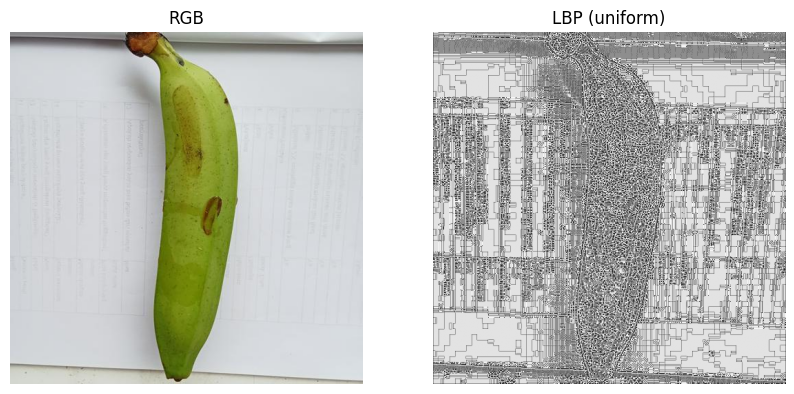

In [32]:
# Demo: compute features on a single example (first JPG found)
root = Path('segmented_masks_gmm_separated/cutouts')
files = sorted(list(root.rglob('*.jpg')) + list(root.rglob('*.png'))) if root.exists() else []
if len(files) == 0:
    print('No images found under segmented_masks_gmm_separated/cutouts — please ensure there are .jpg or .png files')
else:
    p = files[0]
    print('Example image:', p.name)
    img_bgr = cv2.imread(str(p))
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    glcm_feats = compute_glcm_features(img_gray)
    lbp_feats = compute_lbp_hist(img_gray)
    hsv_feats = compute_hsv_hist(img_bgr)
    # merge and show
    feats = {}
    feats.update(glcm_feats)
    feats.update(lbp_feats)
    feats.update(hsv_feats)
    print('Computed feature vector length:', len(feats))
    # show original image and LBP visualization
    lbp_img = local_binary_pattern(img_gray, 8, 1, method='uniform')
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)); plt.title('RGB'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(lbp_img, cmap='gray'); plt.title('LBP (uniform)'); plt.axis('off')
    plt.show()

In [ ]:
# Batch extract features for all images and save CSV
root = Path('segmented_masks_gmm_separated/cutouts')
out_csv = Path('features_glcm_lbp_hsv.csv')
rows = []
if root.exists():
    files = sorted(list(root.rglob('*.jpg')) + list(root.rglob('*.png')))
    for i, p in enumerate(tqdm(files, desc='Extracting features')):
        try:
            img_bgr = cv2.imread(str(p))
            if img_bgr is None:
                print('skip', p)
                continue
            img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
            r = {'filename': p.name}
            r.update(compute_glcm_features(img_gray))
            r.update(compute_lbp_hist(img_gray))
            r.update(compute_hsv_hist(img_bgr))
            rows.append(r)
        except Exception as e:
            print(f'Failed {p}: {e}')
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print(f'Saved features to {out_csv} (rows={len(df)})')
else:
    print('segmented_masks_gmm_separated/cutouts not found — cannot run batch extraction')

Extracting features: 100%|██████████| 3277/3277 [02:38<00:00, 20.72it/s]


Saved features to features_glcm_lbp_hsv.csv (rows=3277)
